### Prepare Data for Training

In [1]:
import pandas as pd
from Demos.SystemParametersInfo import new_dh
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import joblib

In [2]:
df = pd.read_csv('../data/german_prepared.csv')
X = df.drop(columns=['credit_risk'])
y = df['credit_risk']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [3]:
print('Training set:')
print('	Good:', y_train.value_counts()[1])
print('	Bad:', y_train.value_counts()[0])

print()

print('Test set:')
print('	Good:', y_test.value_counts()[1])
print('	Bad:', y_test.value_counts()[0])

Training set:
	Good: 471
	Bad: 199

Test set:
	Good: 229
	Bad: 101


### Random Forest Classifier

In [49]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10],
}

grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='precision_macro')
grid.fit(X_train, y_train)

print(grid.best_params_)

{'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 200}


In [50]:
rf = RandomForestClassifier(
    **grid.best_params_,
	random_state=42
)
rf.fit(X_train, y_train)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.14      0.24       101
           1       0.72      0.98      0.83       229

    accuracy                           0.72       330
   macro avg       0.75      0.56      0.53       330
weighted avg       0.74      0.72      0.65       330



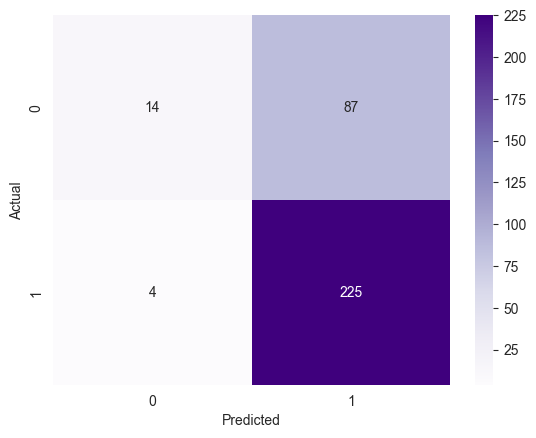

In [51]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')

plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()

In [53]:
class_weight = {0: 1, 1: len(y_train[y_train == 0]) / len(y_train[y_train == 1])}

# Create and train the RandomForestClassifier
rf = RandomForestClassifier(
    **grid.best_params_,
    class_weight=class_weight,
    random_state=42
)


rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.55      0.64      0.59       101
           1       0.83      0.77      0.80       229

    accuracy                           0.73       330
   macro avg       0.69      0.71      0.70       330
weighted avg       0.74      0.73      0.74       330



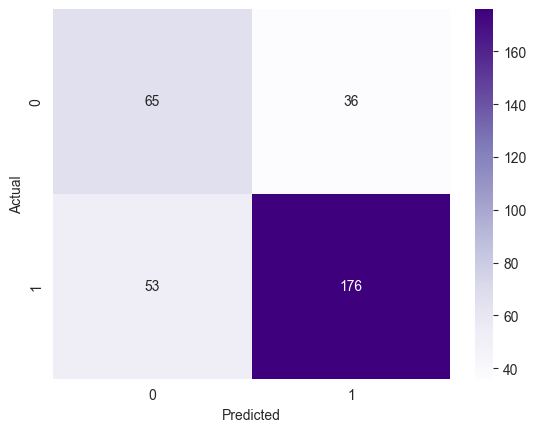

In [54]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')

plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()

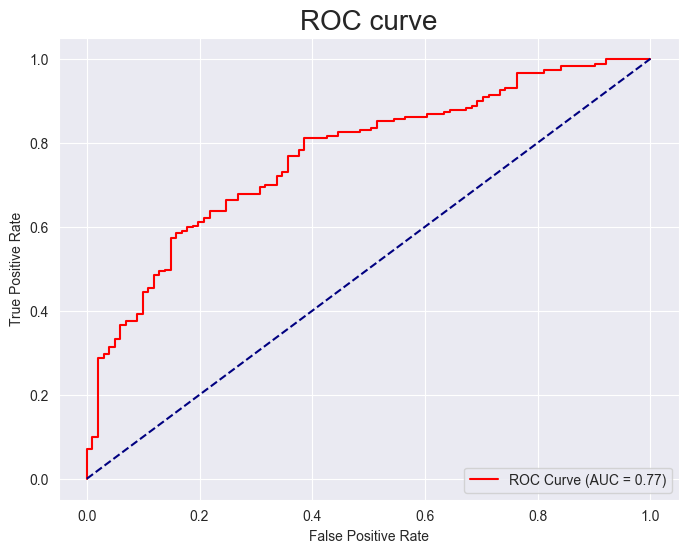

In [55]:
y_probs = rf.predict_proba(X_test)[:, 1]  # Propability of the positive class

fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='red')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC curve', fontsize=20)
plt.legend(loc='lower right')

plt.show()

In [56]:
joblib.dump(rf, '../models/random_forest.joblib')

['../models/random_forest.joblib']

### XGBoost Classifier

In [57]:
def clean_column_names(df):
    df_new = df.copy()
    new_columns = []

    for col in df.columns:
        new_columns.append(col.replace('>', '_').replace('<', '_').replace(',', '_').replace(' ', '_'))

    df_new.columns = new_columns

    return df_new

In [24]:
import xgboost as xgb

xgb_df = clean_column_names(df)
X = xgb_df.drop(columns=['credit_risk'])
y = xgb_df['credit_risk']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0]
}

grid = GridSearchCV(xgb.XGBClassifier(random_state=42), param_grid, cv=5, scoring='precision_macro')
grid.fit(X_train, y_train)

print(grid.best_params_)

C:\Users\kacpe\Desktop\CreditRiskClassification\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}


In [27]:
xgb_model = xgb.XGBClassifier(
    **grid.best_params_,
    random_state=42
)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.17      0.27       101
           1       0.72      0.96      0.82       229

    accuracy                           0.72       330
   macro avg       0.68      0.56      0.54       330
weighted avg       0.69      0.72      0.65       330



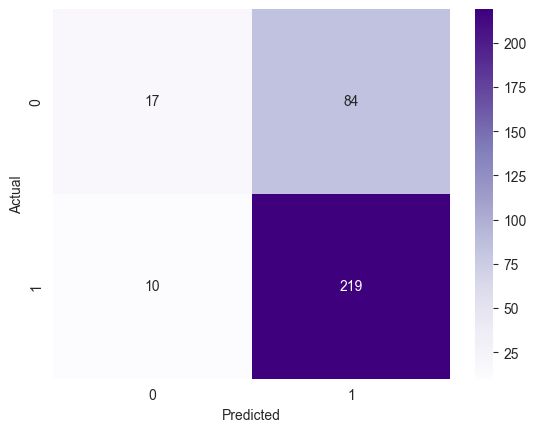

In [29]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')

plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()

In [33]:
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1]) # scale the positive class weight
xgb_model = xgb.XGBClassifier(
    **grid.best_params_,
    scale_pos_weight=scale_pos_weight,
    random_state=42
)

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.49      0.66      0.56       101
           1       0.82      0.69      0.75       229

    accuracy                           0.68       330
   macro avg       0.65      0.68      0.66       330
weighted avg       0.72      0.68      0.69       330



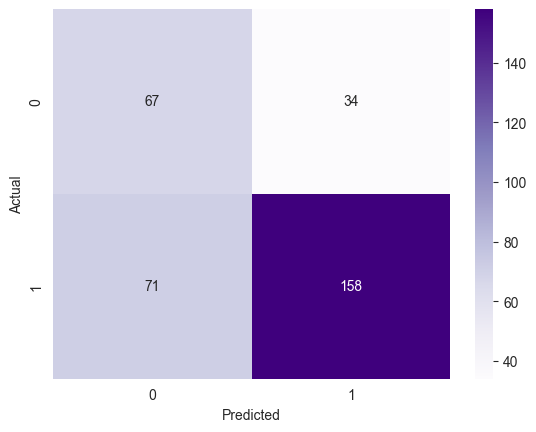

In [34]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')

plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()

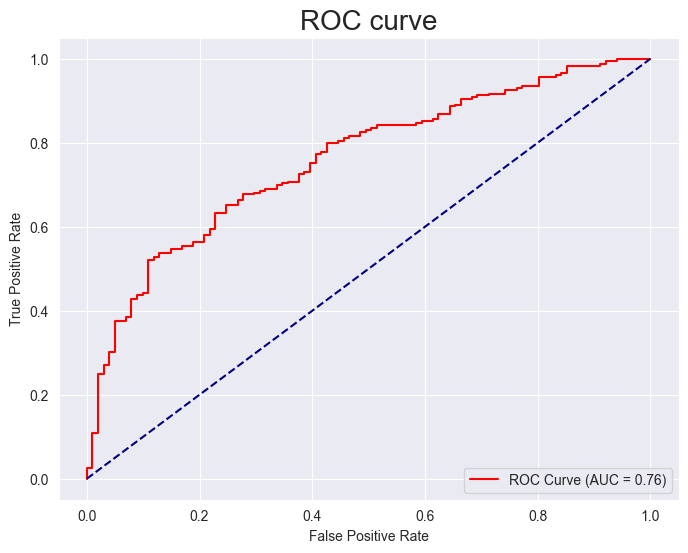

In [40]:
y_probs = xgb_model.predict_proba(X_test)[:, 1]  # Propability of the positive class

fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='red')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC curve', fontsize=20)
plt.legend(loc='lower right')

plt.show()

In [42]:
joblib.dump(xgb_model, '../models/xgboost.joblib')

['../models/xgboost.joblib']

### Porównanie wyników

### Model Comparison: Random Forest vs XGBoost

| Metric                     | Random Forest | XGBoost |
|----------------------------|----------------|----------|
| **Precision (class 0 - bad)** | 0.55 | 0.49 |
| **Recall (class 0 - bad)**    | 0.64 | 0.66 |
| **F1-score (class 0 - bad)**  | 0.59 | 0.56 |
| **Precision (class 1 - good)** | 0.83 | 0.82 |
| **Recall (class 1 - good)**    | 0.77 | 0.69 |
| **F1-score (class 1 - good)**  | 0.80 | 0.75 |
| **Accuracy**                   | 0.73 | 0.68 |
| **Macro Avg F1-score**         | 0.70 | 0.66 |
| **Weighted Avg F1-score**      | 0.74 | 0.69 |
| **ROC AUC**                    | 0.77 | 0.76 |

---

### Key results:

- **Random Forest** shows slightly better overall performance and a marginally higher ROC AUC score.
- Both models demonstrate similar ability to distinguish between risky and low-risk clients, as reflected in the ROC AUC values (0.77 vs. 0.76).
- Random Forest offers more balanced results, while XGBoost still slightly favors detecting high-risk clients.
- In practice, the choice depends on whether the business prioritizes higher overall accuracy or more aggressive risk detection.
